In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os, csv

from dataset import Dataset, ColorHue
Dataset.init('data/')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

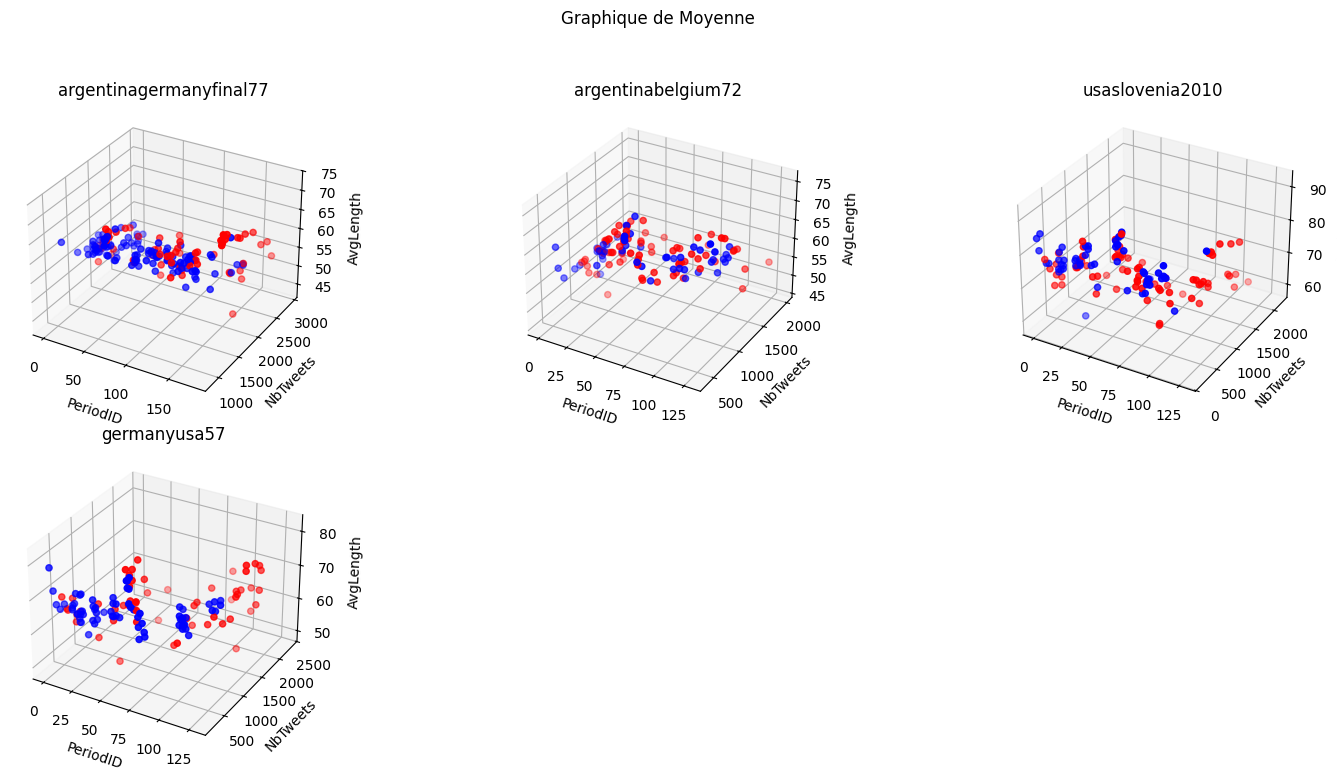

In [2]:
Dataset.TEST.plot(
    source='cleared_enrich',
    agg_func='subplots',  # in 'subplots', 'mean', 'stacked'
    x='PeriodID',
    y='NbTweets',
    z='AvgLength',
    color='EventType',
    title='Graphique de Moyenne',
    color_hue=ColorHue.LABELS_HUE,
    show_hue_legend=False,
    plot_style={'linewidth': 1},
    is_line_chart=False
)

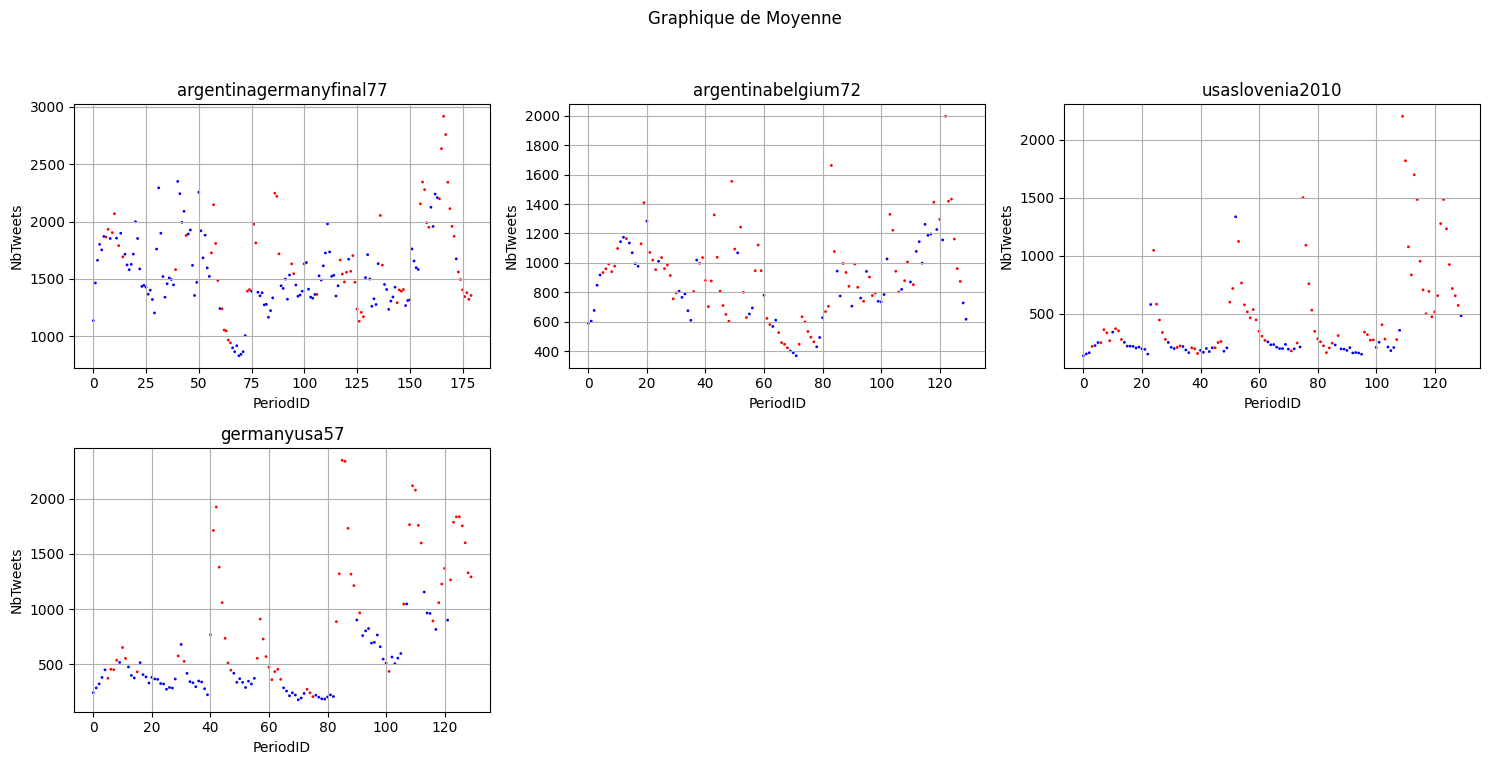

In [3]:
Dataset.TEST.plot(
    source='cleared_enrich',
    agg_func='subplots',  # in 'subplots', 'mean', 'stacked'
    x='PeriodID',
    y='NbTweets',
    color='EventType',
    title='Graphique de Moyenne',
    color_hue=ColorHue.LABELS_HUE,
    show_hue_legend=False,
    # smaller dots
    plot_style={'marker': 'o', 's': 1},
    is_line_chart=False
)

Download the data from ./data/train_tweets/

In [4]:
print(Dataset.TRAIN)
print(Dataset.TEST)
Dataset.TRAIN.setup('cleared_enrich', 64, 32, True)
Dataset.TEST.setup('cleared_enrich', 64, 32, False)
print(Dataset.TRAIN)
print(Dataset.TEST)


 | Dataset(path='data/train_tweets', files=['AustraliaSpain34.csv', 'PortugalGhana58.csv', 'CameroonBrazil36.csv', 'GermanyBrazil74.csv', 'BelgiumSouthKorea59.csv', 'NetherlandsChile35.csv', 'GermanyAlgeria67.csv', 'FranceGermany70.csv', 'MexicoCroatia37.csv', 'FranceNigeria66.csv', 'AustraliaNetherlands29.csv', 'HondurasSwitzerland54.csv'], labeled=True)
 | No setup
 |______

 | Dataset(path='data/train_tweets', files=['ArgentinaGermanyFinal77.csv', 'ArgentinaBelgium72.csv', 'USASlovenia2010.csv', 'GermanyUSA57.csv'], labeled=True)
 | No setup
 |______

 | Dataset(path='data/train_tweets', files=['AustraliaSpain34.csv', 'PortugalGhana58.csv', 'CameroonBrazil36.csv', 'GermanyBrazil74.csv', 'BelgiumSouthKorea59.csv', 'NetherlandsChile35.csv', 'GermanyAlgeria67.csv', 'FranceGermany70.csv', 'MexicoCroatia37.csv', 'FranceNigeria66.csv', 'AustraliaNetherlands29.csv', 'HondurasSwitzerland54.csv'], labeled=True)
 | Setup: {'source': 'cleared_enrich', 'time_step': 32, 'batch_size': 64, 'shuff

CNN in parrallel: https://iopscience.iop.org/article/10.1088/1742-6596/1792/1/012074/pdf

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, timestep, kernel_size:float, kernel_ev, num_layers, 
            out_layers, num_feature=2):
        # padding = (kernel_size - 1) // 2 pour conserver la même longueur.
        # new_channels_size = timesteps - kernel_size + 1
        super(ConvBlock, self).__init__()

        self.layers = nn.ModuleList()
        channel_size = timestep
        for index_layer in range(num_layers):
            if index_layer == 0:
                in_channels = num_feature
                out_channels = 32
                kernel_value = max(int(kernel_size * timestep), 1)
                padding = (kernel_value - 1) // 2
            else:
                in_channels = self.layers[-1].out_channels
                out_channels = in_channels
                kernel_value = self.layers[-1].kernel_size[0]
            
            if out_layers == "keep_length": pass
            elif out_layers == "increase": out_channels = min(2 * out_channels, 256)
            elif out_layers == "decrease": out_channels //= 1.2
            out_channels = max(int(out_channels), 16)

            if kernel_ev == "keep_same": kernel_size = kernel_value if kernel_size < channel_size else channel_size
            elif kernel_ev == "increase": kernel_value += kernel_size < channel_size
            elif kernel_ev == "decrease": kernel_value -= kernel_size > 1

            if kernel_value > channel_size:
                kernel_value = channel_size
            padding = int((kernel_value - 1) // 2)

            self.layers.append(
                nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_value, 
                    padding=padding
                )
            )
            channel_size = int(channel_size - kernel_value + 1 + 2 * padding)
    
        out_channels = channel_size * self.layers[-1].out_channels
        self.out_channels = out_channels
        self.channel_size = channel_size
        self.flat_out_channels = self.layers[-1].out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = torch.relu(x)
        return x


In [7]:
class ParalleleTCN(nn.Module):
    def __init__(self, timestep, kernel_size:float, kernel_ev, 
            num_layers, out_layers, nb_parallel, num_feature=2):
        super(ParalleleTCN, self).__init__()
        self.conv = nn.ModuleList()
        for _ in range(nb_parallel):
            self.conv.append(ConvBlock(timestep, kernel_size, kernel_ev, num_layers, out_layers, num_feature))
        

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.conv[-1].out_channels * nb_parallel, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, feature, timestep) -> (batch, timestep, feature)
        # Merge the parallel models
        x = torch.cat([conv(x) for conv in self.conv], dim=1)
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Définir le modèle TCN
class TCN(nn.Module):
    def __init__(self, timestep, kernel_size:float, kernel_ev, num_layers, 
            out_layers, num_feature=2):
        # padding = (kernel_size - 1) // 2 pour conserver la même longueur.
        # new_channels_size = timesteps - kernel_size + 1
        super(TCN, self).__init__()

        self.layers = nn.ModuleList()
        channel_size = timestep
        for index_layer in range(num_layers):
            if index_layer == 0:
                in_channels = num_feature
                out_channels = 32
                kernel_value = max(int(kernel_size * timestep), 1)
                padding = (kernel_value - 1) // 2
            else:
                in_channels = self.layers[-1].out_channels
                out_channels = in_channels
                kernel_value = self.layers[-1].kernel_size[0]
            
            if out_layers == "keep_length": pass
            elif out_layers == "increase": out_channels = min(2 * out_channels, 256)
            elif out_layers == "decrease": out_channels //= 1.2
            out_channels = max(int(out_channels), 16)

            if kernel_ev == "keep_same": kernel_size = kernel_value if kernel_size < channel_size else channel_size
            elif kernel_ev == "increase": kernel_value += kernel_size < channel_size
            elif kernel_ev == "decrease": kernel_value -= kernel_size > 1

            if kernel_value > channel_size:
                kernel_value = channel_size
            padding = int((kernel_value - 1) // 2)

            self.layers.append(
                nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_value, 
                    padding=padding
                )
            )
            channel_size = int(channel_size - kernel_value + 1 + 2 * padding)

        in_channels = self.layers[-1].out_channels * channel_size
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(in_channels, 2)

    def forward(self, x):
        # x doit être de forme [batch_size, num_features, timesteps]
        x = x.permute(0, 2, 1) # brefore [batch_size, timesteps, num_features]
        for layer in self.layers:
            x = layer(x) 
            x = torch.relu(x)
        
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [64]:
#https://medium.com/@clairenyz/attention-based-convolutional-neural-network-a719693058a7
import math
class MultiInputTCN(nn.Module):
    def __init__(self, timestep, kernel_size:float, kernel_ev, num_layers, 
            out_layers, zoom_factor, num_feature=2):
        # zoom_factor > 1
        # padding = (kernel_size - 1) // 2 pour conserver la même longueur.
        # new_channels_size = timesteps - kernel_size + 1
        super(MultiInputTCN, self).__init__()

        self.conv_block1 = ConvBlock(timestep, kernel_size, kernel_ev, num_layers, out_layers, num_feature)

        timestep_block2 = math.floor(timestep / zoom_factor)
        stride = math.floor(timestep / timestep_block2)
        kernel_size = timestep - (timestep_block2 - 1) * stride

        print(f"Kernel size: {kernel_size}, stride: {stride}")

        self.maxpool_b1_b2 = nn.MaxPool1d(kernel_size, stride=stride)
        self.conv_block2 = ConvBlock(timestep_block2, kernel_size, kernel_ev, num_layers, out_layers)

        timestep_block3 = math.floor(timestep_block2 / zoom_factor)
        stride = math.floor(timestep_block2 / timestep_block3)
        kernel_size = timestep_block2 - (timestep_block3 - 1) * stride

        self.maxpool_b2_b3 = nn.MaxPool1d(kernel_size, stride=stride)
        self.conv_block3 = ConvBlock(timestep_block3, kernel_size, kernel_ev, num_layers, out_layers)
        
        channel_size = self.conv_block1.channel_size + self.conv_block2.channel_size + self.conv_block3.channel_size
        in_channels = self.conv_block1.flat_out_channels
        print(f"One in_channels: {self.conv_block1.flat_out_channels}, {self.conv_block2.flat_out_channels}, {self.conv_block3.flat_out_channels}")
        print(f"Channel size: {channel_size}, in_channels: {in_channels}")
        
        self.conv4 = nn.Conv1d(in_channels, 128, channel_size)
        # self.conv_block4 = ConvBlock(channel_size, kernel_size, kernel_ev, num_layers, out_layers, in_channels)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        # print(f"X: {x.shape}")
        x1_out = self.conv_block1(x)

        x2 = self.maxpool_b1_b2(x)
        # x2 + x1_out
        x2 = torch.cat([x1_out, x2], dim=2)
        # print(f"X2: {x2.shape}")
        x2_out = self.conv_block2(x2)

        x3 = self.maxpool_b2_b3(x2)
        # print(f"X3: {x3.shape}")
        x3_out = self.conv_block3(x3)

        x = torch.cat([x1_out, x2_out, x3_out], dim=2)
        # print(f"X4: {x.shape}")
        x = self.conv4(x)

        # print(f"Out: {x.shape}")
        x = x.view(x.size(0), -1)
        # print(f"Out2: {x.shape}")
        x = self.dropout(x)
        x = self.fc(x)
        return x
        

In [215]:
# hyperparamètres à tester: timesteps, kernel_size, padding, kernel_size_through_layers, num_layers, out layers
timesteps = [3, 4, 5, 8, 16, 32]
kernel_size_in_percent_of_timesteps = [0.2, 0.5, 0.7] # cast to int
kernel_size_through_layers = ["keep_same", "increase", "decrease"]
num_layers = [2, 3, 4]
out_layers = ["keep_length", "decrease", "increase"]

# Générer toutes les combinaisons de paramètres
params_combinations = [
    (k, ktl, nl, ol)
    for k in kernel_size_in_percent_of_timesteps
    for ktl in kernel_size_through_layers
    for nl in num_layers
    for ol in out_layers
]

print(f"Number of combinations of hyperparameters: {len(params_combinations) * len(timesteps)}")
# sortir les timesteps pour optimiser le temps de calcul (limiter le nombre d'appel à preprocess_data)


"""[{timestep: int, kernel_size: int, padding: str, kernel_size_through_layers: str, num_layers: int, out_layers: str, accuracy_train: [float], loss_train: [], accuracy_test: float}]"""
input_size = 2
criterion = nn.CrossEntropyLoss()


def test_model(timestep, params_combinations, train, test):
    results: list[dict] = []
    index = 0

    X_train, test_loader = preprocess_data(train, test, timestep)
    for kernel, kernel_layers, num_layers, out_layers in params_combinations:
        index += 1
        print(f"[Training] [{timestep} step] [{index}/{len(params_combinations)}]")
        try:
            model = TCN(timestep=timestep, kernel_size=kernel, kernel_ev=kernel_layers, num_layers=num_layers, out_layers=out_layers)
        except Exception as e:
            print(f"Error while creating model with timestep: \n{timestep}, kernel_size: {kernel}, \nkernel_size_through_layers: {kernel_layers}, num_layers: {num_layers}, out_layers: {out_layers}")
            raise e
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        model.to(device)
        model.train()
        current_results = {
            "timestep": timestep,
            "kernel_size": kernel,
            "kernel_size_through_layers": kernel_layers,
            "num_layers": num_layers,
            "out_layers": out_layers,
            "accuracy_train": [],
            "loss_train": [],
            "accuracy_test": 0
        }

        for epoch in range(1, 75):
            for key in X_train:
                train_loader = X_train[key]
                for i, (X_batch, y_batch) in enumerate(train_loader):
                    # Forward pass
                    optimizer.zero_grad()
                    try:
                        outputs = model(X_batch)
                    except Exception as e:
                        print(f"Error while training model with timestep: \n{timestep}, kernel_size: {kernel}, \nkernel_size_through_layers: {kernel_layers}, num_layers: {num_layers}, out_layers: {out_layers}")
                        raise e
                    
                    loss = criterion(outputs, y_batch)

                    if len(current_results["loss_train"]) < epoch:
                        current_results["loss_train"].append(loss.item())
                        current_results["accuracy_train"].append((outputs.argmax(1) == y_batch).float().mean().item())
                    loss.backward()
                    optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = 100 * correct / total
        current_results["accuracy_test"] = accuracy
        results.append(current_results)

        print(f"[Test] Accuracy: {accuracy}")
    
    print(f"Finished training for timestep: {timestep}")
    return results

results: list[dict] = []
    
for timestep in timesteps:
    results.extend(test_model(timestep, params_combinations, train, test))
        
# Sauvegarder les résultats
with open("results.csv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)


Number of combinations of hyperparameters: 486


KeyboardInterrupt: 

In [11]:
#load results
results = pd.read_csv("results.csv")
# print(results.head())
# create max train accuracy column and an other for test accuracy
results["max_accuracy_train"] = results["accuracy_train"].apply(lambda x: max(x))

NB_MODELS = 10
# show the 10 best models
best_models = results.sort_values("accuracy_test", ascending=False).head(NB_MODELS)

# plot the best models
# a chart by model: train accuracy evolution, loss evolution over epochs
# title: accuracy test + hyperparameters
# x axis: epochs
# y axis: accuracy or loss

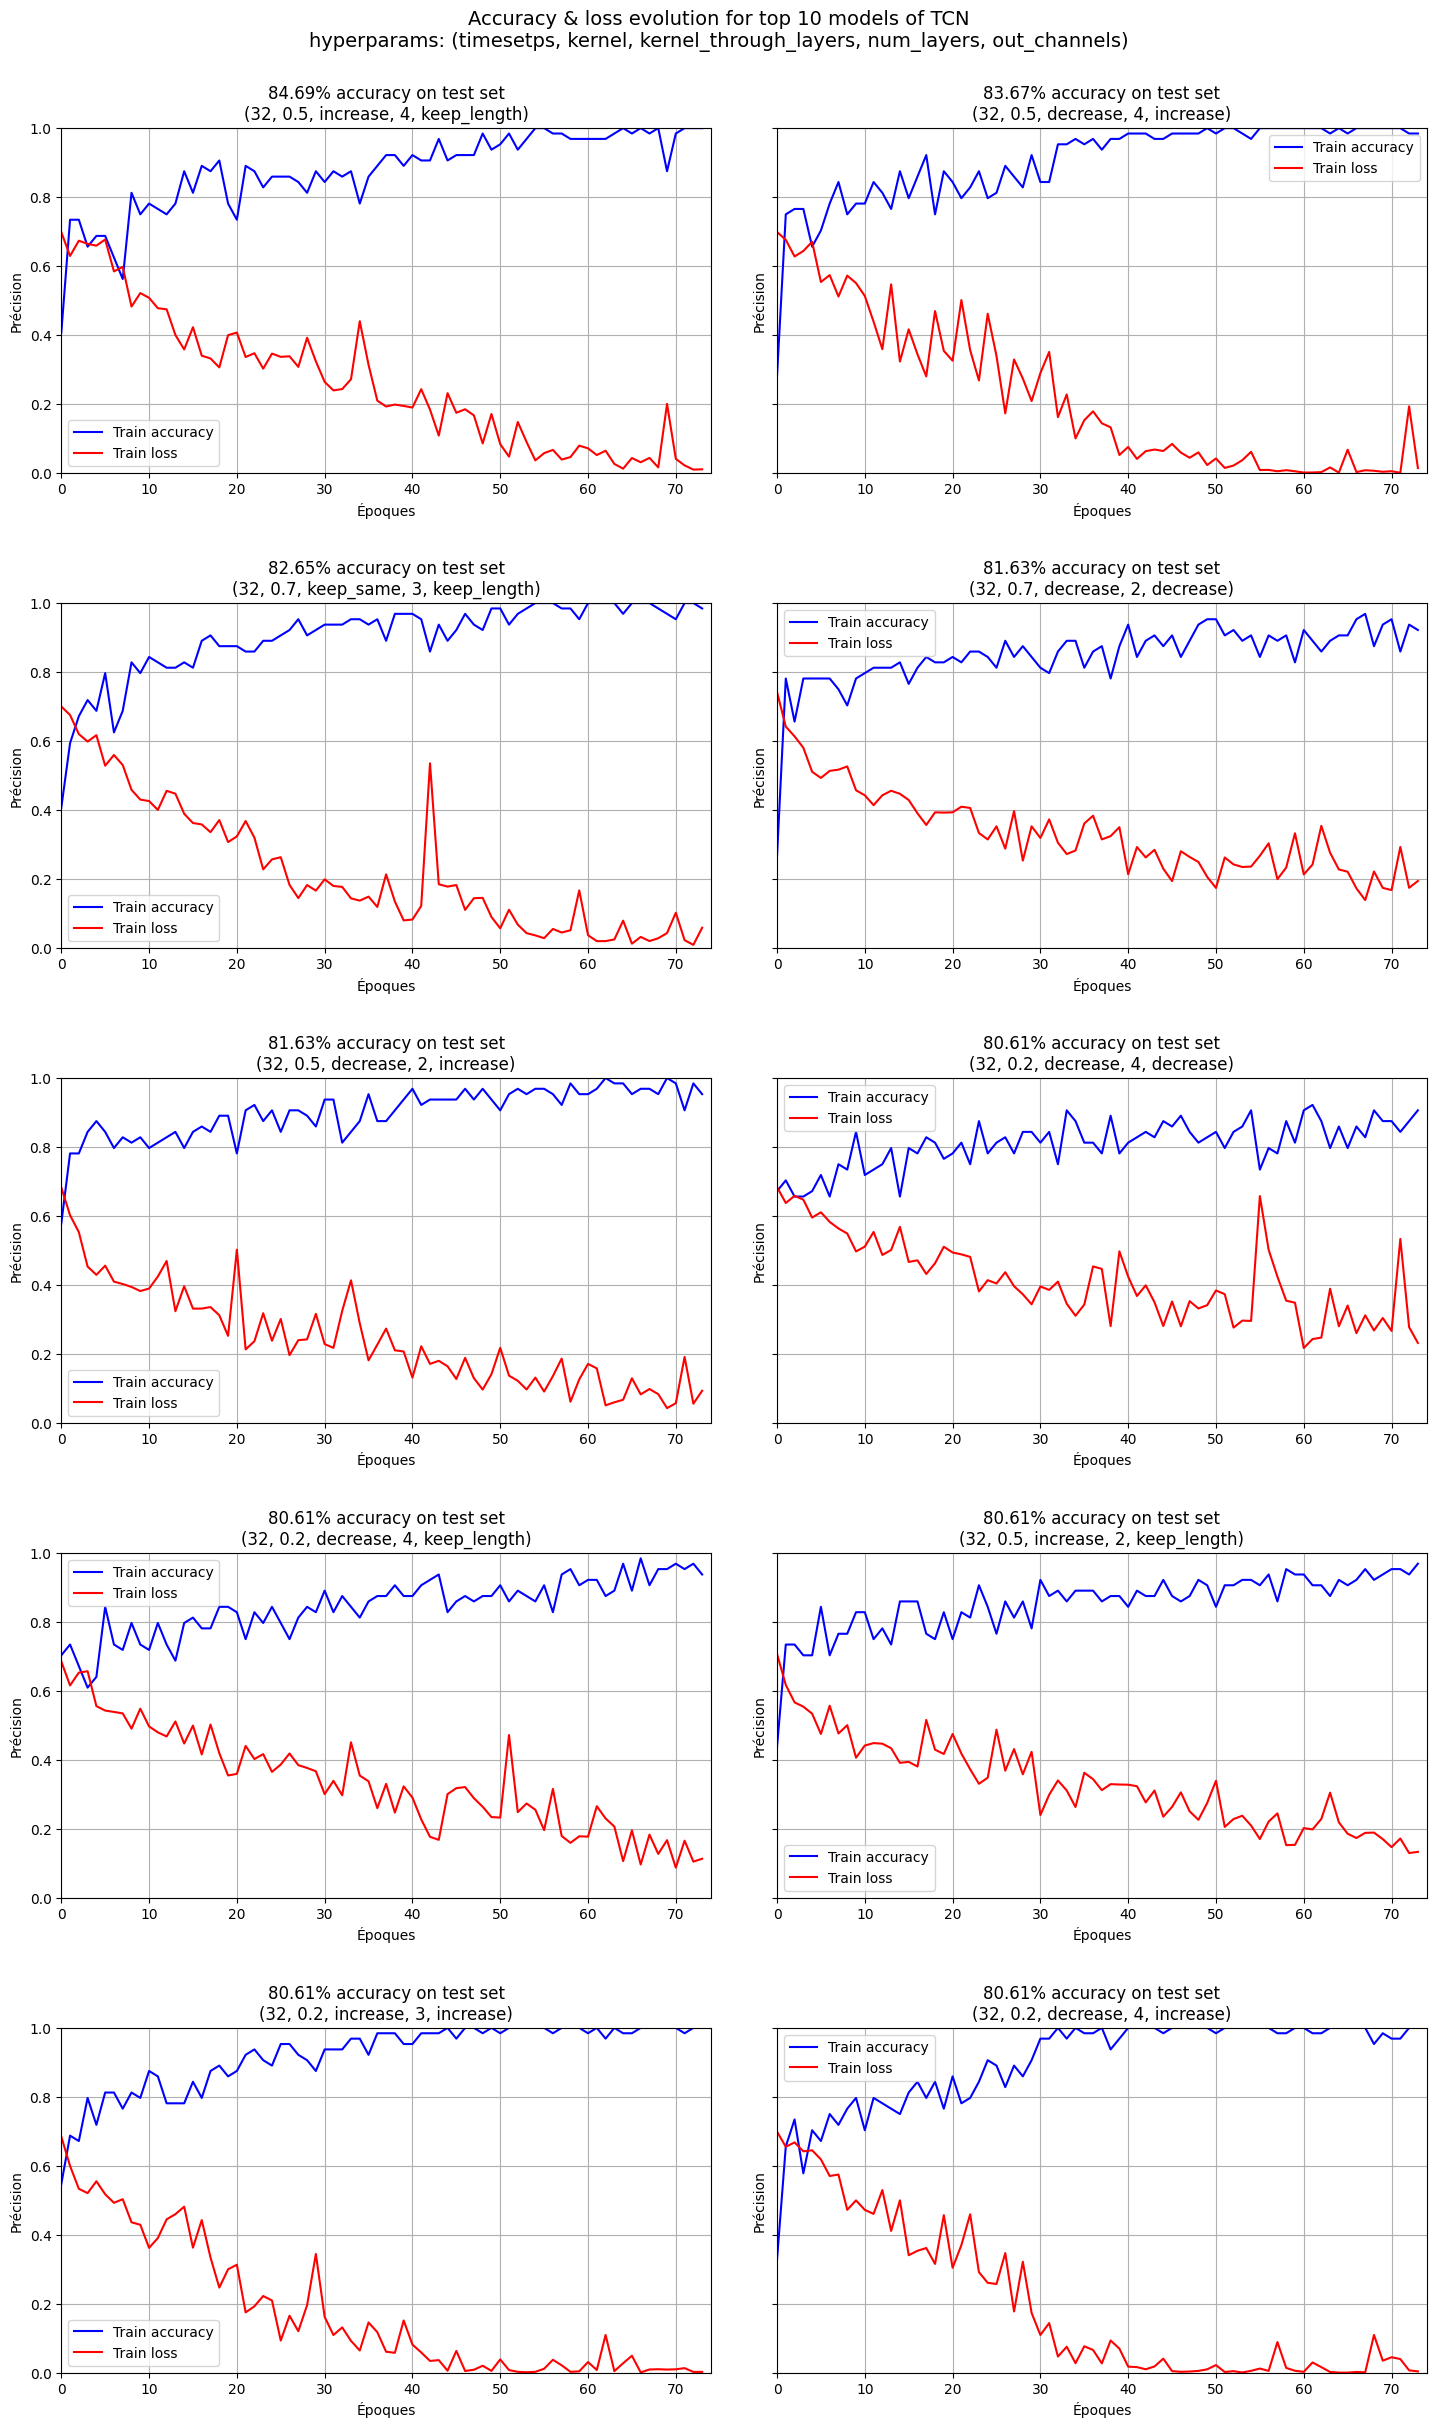

In [69]:
import json

fig, axes = plt.subplots(NB_MODELS // 2, 2, figsize=(15, 25), sharey=True)
axes = axes.flatten()

for index, (_, row) in enumerate(best_models.iterrows()):
    accuracy_train = json.loads(row["accuracy_train"])
    loss_train = json.loads(row["loss_train"])

    ax = axes[index]
    ax.plot(accuracy_train, label="Train accuracy", color='blue')
    ax.plot(loss_train, label="Train loss", color='red')
    # Définir le titre avec précision de test et hyperparamètres
    ax.set_title(
        f"{row['accuracy_test']:.2f}% accuracy on test set\n"
        f"({row['timestep']}, {row['kernel_size']}, "
        f"{row['kernel_size_through_layers']}, {row['num_layers']}, "
        f"{row['out_layers']})"
    )
    
    # Définir les labels des axes
    ax.set_xlabel("Époques")
    ax.set_ylabel("Précision")
    
    # Fixer les mêmes limites pour l'axe Y
    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(accuracy_train))
    
    # Ajouter une légende et une grille
    ax.legend()
    ax.grid(True)

fig.suptitle(f"Accuracy & loss evolution for top {NB_MODELS} models of TCN\nhyperparams: (timesetps, kernel, kernel_through_layers, num_layers, out_channels)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste l'espace pour le suptitle
plt.tight_layout(pad=3.0)
plt.show()

In [276]:
# redo best models training
best_models_results = {}
X_train, test_loader, last_timestep = None, None, None
for index, (_, row) in enumerate(best_models.iterrows()):
    if index == 1: continue # trop lent
    print(f"Training model {index + 1}/{NB_MODELS}")

    model = TCN(timestep=row["timestep"], kernel_size=row["kernel_size"], kernel_ev=row["kernel_size_through_layers"], num_layers=row["num_layers"], out_layers=row["out_layers"])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)  # Ajout du scheduler

    if last_timestep != row["timestep"]:
        print(f"Preprocessing data for timestep: {row['timestep']}")
        X_train, test_loader = preprocess_data(cleared_train, cleared_test, row["timestep"])
        last_timestep = row["timestep"]

    
    model.to(device)
    model.train()
    current_results = {
        "accuracy_train": [],
        "loss_train": [],
        "accuracy_test": []
    }

    for epoch in range(1, 26):
        for key in X_train:
            train_loader = X_train[key]
            for i, (X_batch, y_batch) in enumerate(train_loader):
                # Forward pass
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                if len(current_results["loss_train"]) < epoch:
                    current_results["loss_train"].append(loss.item())
                    current_results["accuracy_train"].append((outputs.argmax(1) == y_batch).float().mean().item())
        
        scheduler.step()
        # test model after each epoch
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = 100 * correct / total
        current_results["accuracy_test"].append(accuracy)
        print(f"Epoch {epoch}: Test accuracy: {accuracy}")

    best_models_results[index] = current_results

# Sauvegarder les résultats
with open("best_models_results_on_cleared_data.json", "w") as f:
    json.dump(best_models_results, f)



Training model 1/10
Preprocessing data for timestep: 32
Epoch 1: Test accuracy: 65.65656565656566
Epoch 2: Test accuracy: 69.6969696969697
Epoch 3: Test accuracy: 73.73737373737374
Epoch 4: Test accuracy: 75.75757575757575
Epoch 5: Test accuracy: 82.82828282828282
Epoch 6: Test accuracy: 84.84848484848484
Epoch 7: Test accuracy: 80.8080808080808
Epoch 8: Test accuracy: 79.79797979797979
Epoch 9: Test accuracy: 81.81818181818181
Epoch 10: Test accuracy: 81.81818181818181
Epoch 11: Test accuracy: 80.8080808080808
Epoch 12: Test accuracy: 81.81818181818181
Epoch 13: Test accuracy: 81.81818181818181
Epoch 14: Test accuracy: 82.82828282828282
Epoch 15: Test accuracy: 86.86868686868686
Epoch 16: Test accuracy: 88.88888888888889
Epoch 17: Test accuracy: 83.83838383838383
Epoch 18: Test accuracy: 88.88888888888889
Epoch 19: Test accuracy: 86.86868686868686
Epoch 20: Test accuracy: 85.85858585858585
Epoch 21: Test accuracy: 85.85858585858585
Epoch 22: Test accuracy: 85.85858585858585
Epoch 23: 

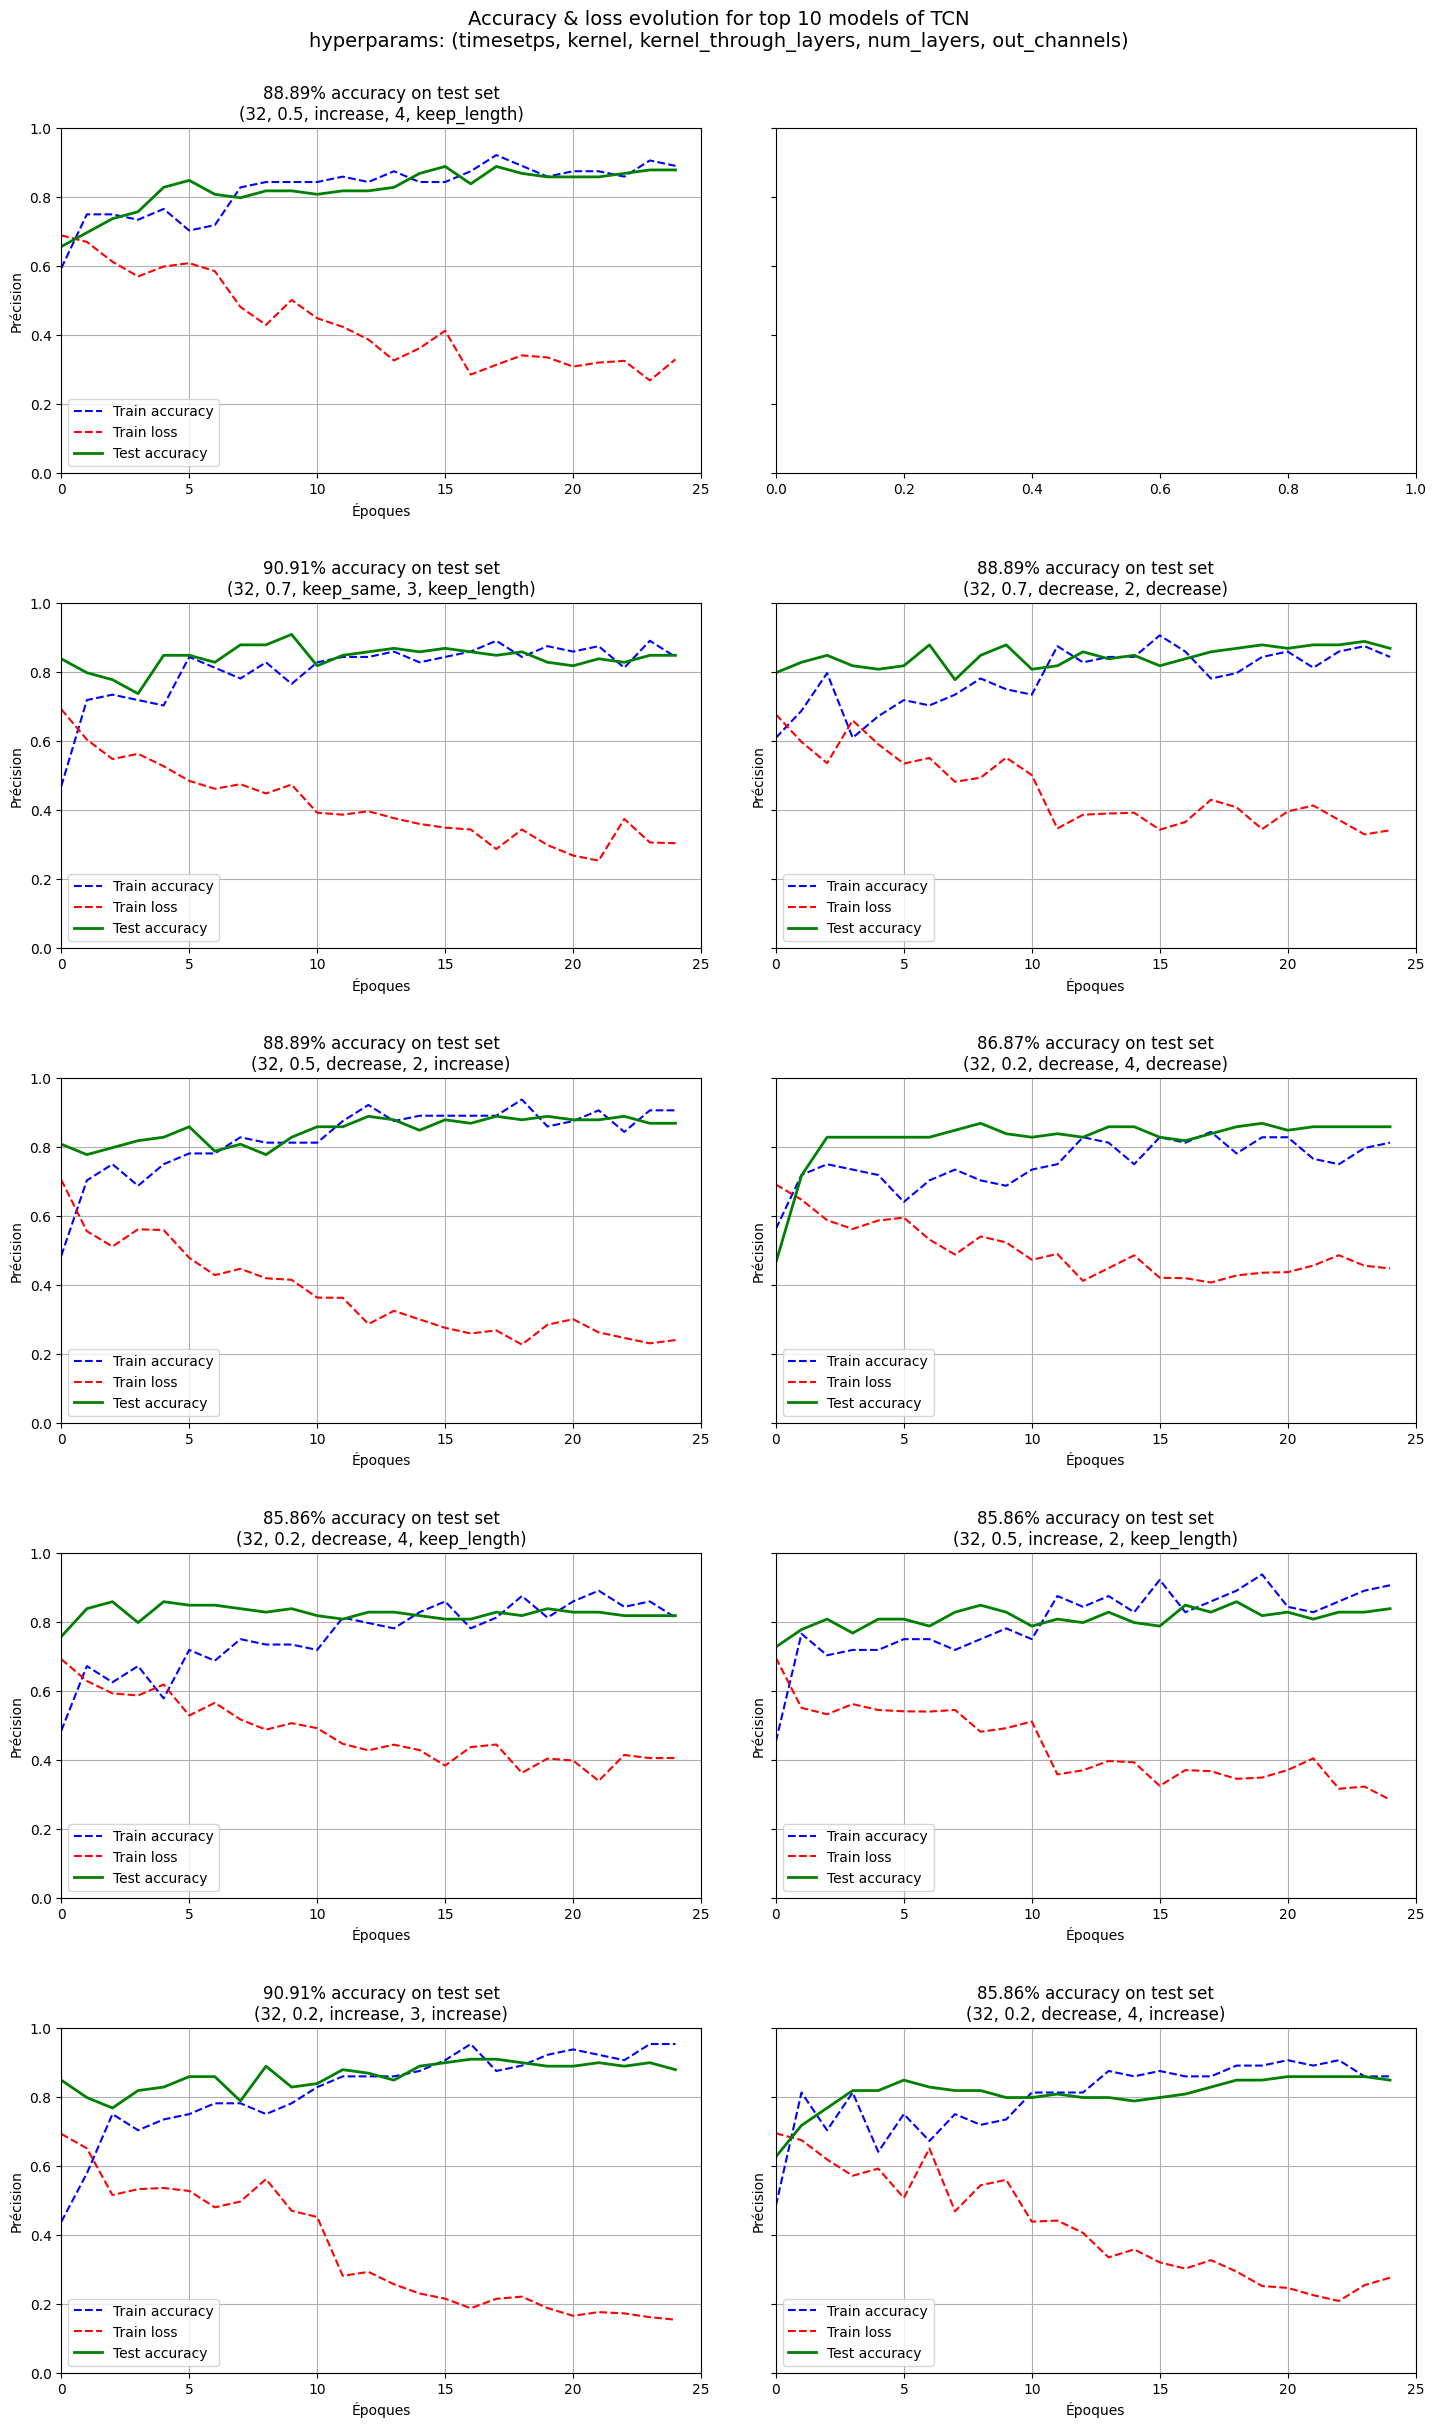

In [277]:
# plot the best models
# a chart by model: train accuracy evolution, loss evolution over epochs
# title: accuracy test + hyperparameters
# x axis: epochs
# y axis: accuracy or loss

best_models_results = json.load(open("best_models_results_on_cleared_data.json"))
best_models_results = {int(k): v for k, v in best_models_results.items()}

fig, axes = plt.subplots(NB_MODELS // 2, 2, figsize=(15, 25), sharey=True)
axes = axes.flatten()

for index, (_, row) in enumerate(best_models.iterrows()):
    if index == 1: continue # trop lent
    accuracy_train = best_models_results[index]["accuracy_train"]
    loss_train = best_models_results[index]["loss_train"]
    accuracy_test = [val / 100 for val in best_models_results[index]["accuracy_test"]]

    ax = axes[index]
    ax.plot(accuracy_train, label="Train accuracy", color='blue', linestyle='--')
    ax.plot(loss_train, label="Train loss", color='red', linestyle='--')
    # accuracy_test: épaisseur de la ligne plus grande
    ax.plot(accuracy_test, label="Test accuracy", color='green', linewidth=2)
    # Définir le titre avec précision de test et hyperparamètres
    ax.set_title(
        f"{max(accuracy_test)*100:.2f}% accuracy on test set\n"
        f"({row['timestep']}, {row['kernel_size']}, "
        f"{row['kernel_size_through_layers']}, {row['num_layers']}, "
        f"{row['out_layers']})"
    )
    
    # Définir les labels des axes
    ax.set_xlabel("Époques")
    ax.set_ylabel("Précision")
    
    # Fixer les mêmes limites pour l'axe Y
    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(accuracy_train))
    
    # Ajouter une légende et une grille
    ax.legend()
    ax.grid(True)

fig.suptitle(f"Accuracy & loss evolution for top {NB_MODELS} models of TCN\nhyperparams: (timesetps, kernel, kernel_through_layers, num_layers, out_channels)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste l'espace pour le suptitle
plt.tight_layout(pad=3.0)
plt.show()


In [163]:
#test the best model but with parrallel TCN
best_models_results = {}
X_train, test_loader, last_timestep = None, None, None

nb_parallel = [1, 2, 3, 4]

for index, (_, row) in enumerate(best_models.iterrows()):
    if index == 1: continue

    if last_timestep != row["timestep"]:
        print(f"Preprocessing data for timestep: {row['timestep']}")
        X_train, test_loader = preprocess_data(cleared_train, cleared_test, row["timestep"])
        last_timestep = row["timestep"]

    for nb in nb_parallel:
        print(f"Training model {index + 1}/{NB_MODELS} with {nb} parallel TCN")

        model = ParalleleTCN(timestep=row["timestep"], kernel_size=row["kernel_size"], kernel_ev=row["kernel_size_through_layers"], num_layers=row["num_layers"], out_layers=row["out_layers"], nb_parallel=nb, num_feature=3)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

        model.to(device)
        model.train()
        current_results = {
            "accuracy_train": [],
            "loss_train": [],
            "accuracy_test": []
        }

        for epoch in range(1, 16):
            for key in X_train:
                train_loader = X_train[key]
                for i, (X_batch, y_batch) in enumerate(train_loader):
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

                    if len(current_results["loss_train"]) < epoch:
                        current_results["loss_train"].append(loss.item())
                        current_results["accuracy_train"].append((outputs.argmax(1) == y_batch).float().mean().item())
            
            scheduler.step()
            # test model after each epoch
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs.data, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch).sum().item()
            accuracy = 100 * correct / total
            current_results["accuracy_test"].append(accuracy)
            print(f"Epoch {epoch}: Test accuracy: {accuracy}")

        best_models_results[f"{index}_{nb}"] = current_results
    
# Sauvegarder les résultats
with open("best_models_results_on_cleared_data_parallel.json", "w") as f:
    json.dump(best_models_results, f)



Preprocessing data for timestep: 32
Training model 1/10 with 1 parallel TCN
Epoch 1: Test accuracy: 46.15384615384615
Epoch 2: Test accuracy: 56.92307692307692
Epoch 3: Test accuracy: 47.69230769230769
Epoch 4: Test accuracy: 43.84615384615385
Epoch 5: Test accuracy: 46.92307692307692
Epoch 6: Test accuracy: 46.15384615384615
Epoch 7: Test accuracy: 44.61538461538461
Epoch 8: Test accuracy: 56.15384615384615
Epoch 9: Test accuracy: 46.15384615384615
Epoch 10: Test accuracy: 45.38461538461539
Epoch 11: Test accuracy: 45.38461538461539
Epoch 12: Test accuracy: 47.69230769230769
Epoch 13: Test accuracy: 48.46153846153846
Epoch 14: Test accuracy: 50.76923076923077
Epoch 15: Test accuracy: 65.38461538461539
Training model 1/10 with 2 parallel TCN
Epoch 1: Test accuracy: 44.61538461538461
Epoch 2: Test accuracy: 63.07692307692308
Epoch 3: Test accuracy: 56.92307692307692
Epoch 4: Test accuracy: 54.61538461538461
Epoch 5: Test accuracy: 54.61538461538461
Epoch 6: Test accuracy: 53.84615384615

KeyboardInterrupt: 

NameError: name 'best_models' is not defined

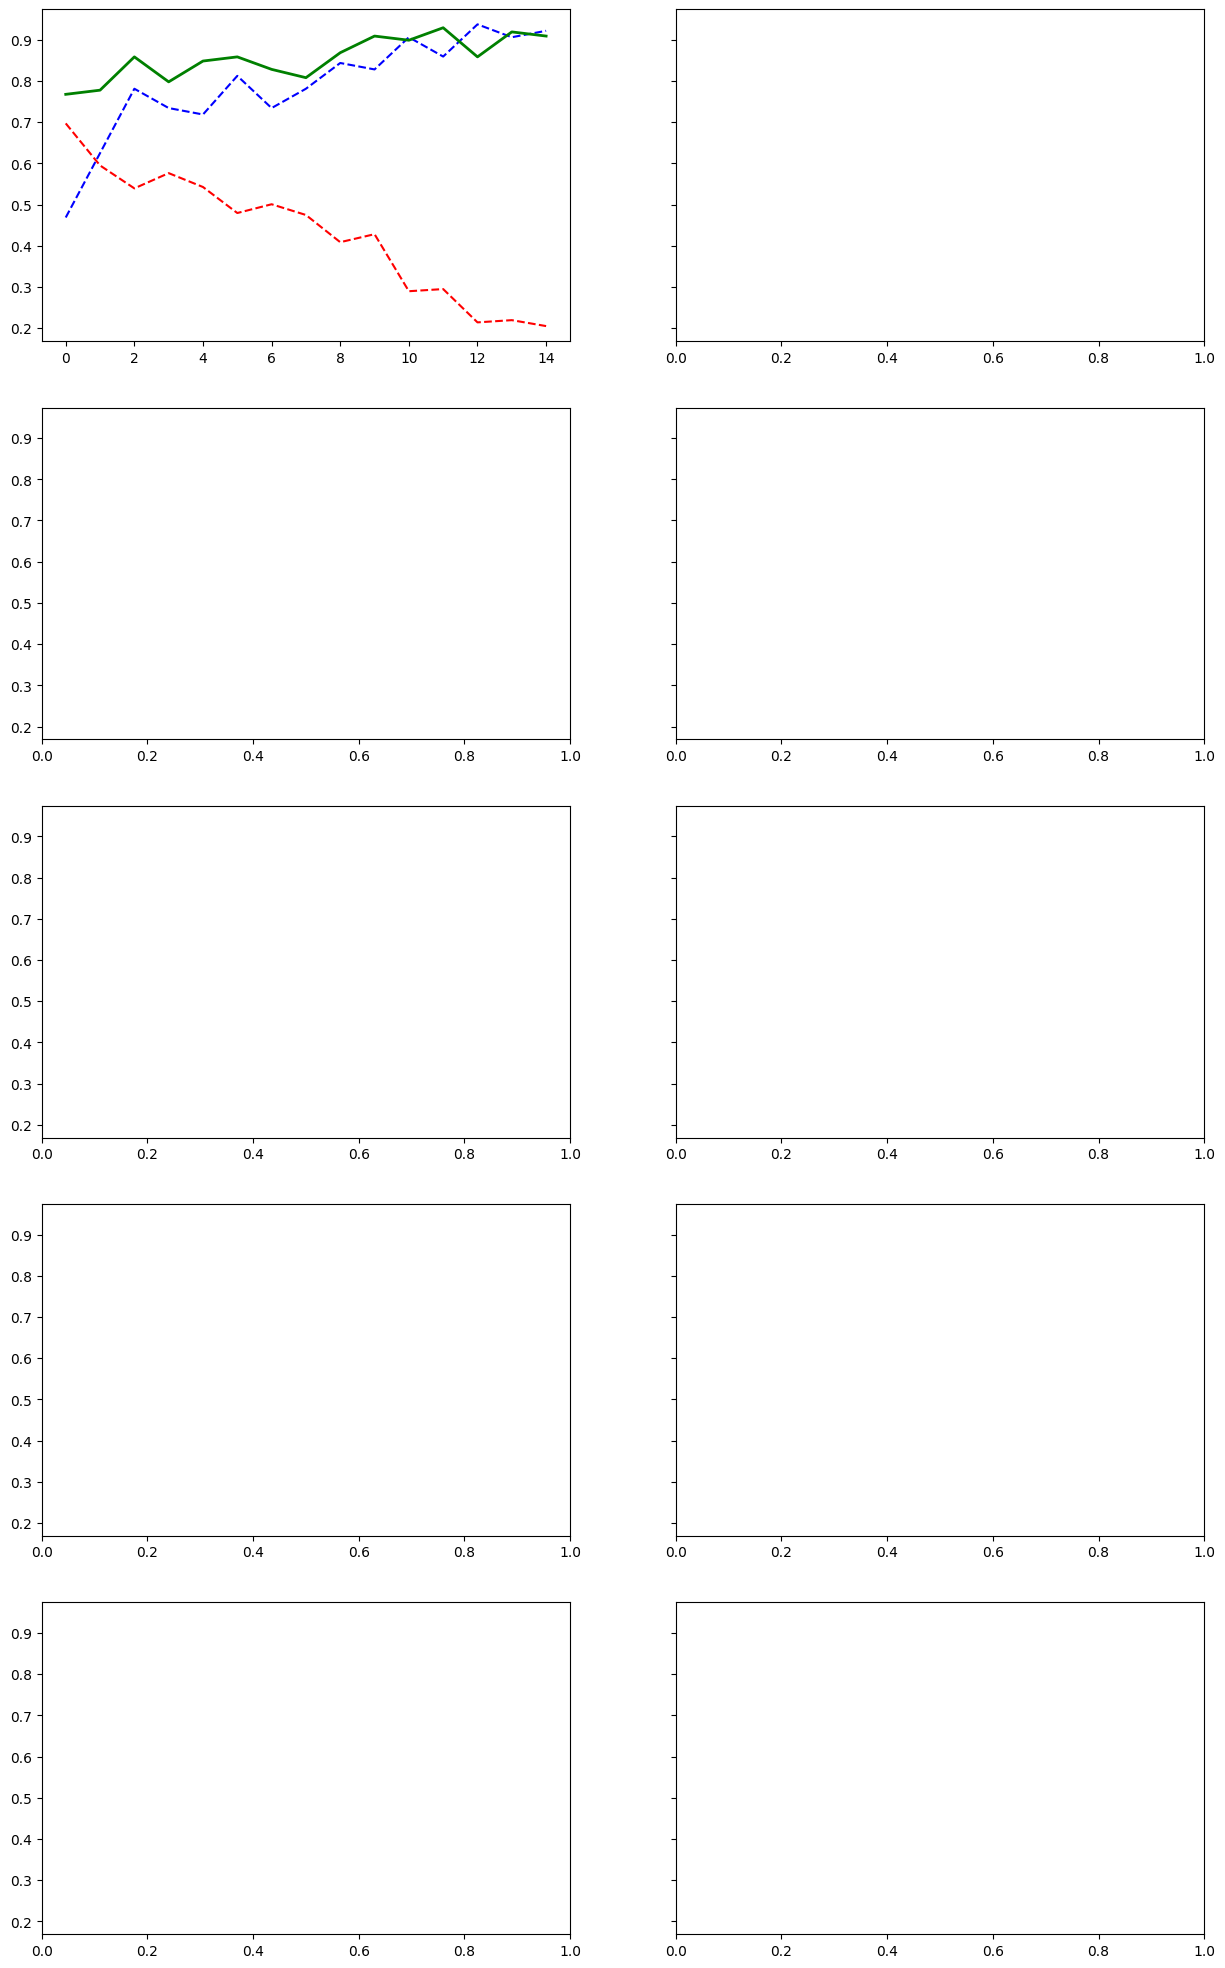

In [15]:
# extract the best parallel model
best_models_results = json.load(open("best_models_results_on_cleared_data_parallel.json"))

best_parallel_models = {}
for key, value in best_models_results.items():
    best_parallel_models[key] = max(value["accuracy_test"])

best_parallel_models = {k: v for k, v in sorted(best_parallel_models.items(), key=lambda item: item[1], reverse=True)}
NB_MODELS = 10
best_parallel_models = {k: best_models_results[k] for k in list(best_parallel_models.keys())[:NB_MODELS]}

# plot the best models
# a chart by model: train accuracy evolution, loss evolution over epochs
# title: accuracy test + hyperparameters
# x axis: epochs
# y axis: accuracy or loss

fig, axes = plt.subplots(NB_MODELS // 2, 2, figsize=(15, 25), sharey=True)
axes = axes.flatten()

for index, (key, row) in enumerate(best_parallel_models.items()):
    accuracy_train = row["accuracy_train"]
    loss_train = row["loss_train"]
    accuracy_test = [val / 100 for val in row["accuracy_test"]]

    ax = axes[index]
    ax.plot(accuracy_train, label="Train accuracy", color='blue', linestyle='--')
    ax.plot(loss_train, label="Train loss", color='red', linestyle='--')
    # accuracy_test: épaisseur de la ligne plus grande
    ax.plot(accuracy_test, label="Test accuracy", color='green', linewidth=2)
    # Définir le titre avec précision de test et hyperparamètres
    model_index, nb_parallel = key.split("_")
    ax.set_title(
        f"{max(accuracy_test)*100:.2f}% accuracy on test set #{model_index}\n"
        f"({best_models.iloc[int(model_index)]['timestep']}, {best_models.iloc[int(model_index)]['kernel_size']}, "
        f"{best_models.iloc[int(model_index)]['kernel_size_through_layers']}, {best_models.iloc[int(model_index)]['num_layers']}, "
        f"{best_models.iloc[int(model_index)]['out_layers']}) with {nb_parallel} parallel TCN"
    )
    
    # Définir les labels des axes
    ax.set_xlabel("Époques")
    ax.set_ylabel("Précision")
    
    # Fixer les mêmes limites pour l'axe Y
    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(accuracy_train))
    
    # Ajouter une légende et une grille
    ax.legend()
    ax.grid(True)

fig.suptitle(f"Accuracy & loss evolution for top {NB_MODELS} models of TCN\nhyperparams: (timesetps, kernel, kernel_through_layers, num_layers, out_channels)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste l'espace pour le suptitle
plt.tight_layout(pad=3.0)
plt.show()

# Need to try attention mechanism and residual connections
# Compare with RNN
# Add the feature nb 3 (variance of characters) 32, 0.2, "increase", 3, "increase", 3 = best

In [160]:
#use best model with 32, 0.2, "increase", 3, "increase", 3 on test finally
def set_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(0)

# cleared_train2 = cleared_train.copy()
# cleared_train2[list(cleared_test.keys())[0]] = list(cleared_test.values())[0]
data_train, test_loader = preprocess_data(cleared_train, cleared_test, 32)

eval_files = os.listdir("data/eval_tweets")
eval_files = [file for file in eval_files if file.endswith(".csv")]
eval_files = {file: pd.read_csv(f"data/eval_tweets/{file}") for file in eval_files}
all_eval, _ = preprocess_data(eval_files, None, 32)

model = ParalleleTCN(timestep=32, kernel_size=0.2, kernel_ev="increase", num_layers=3, out_layers="increase", nb_parallel=3, num_feature=3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

model.to(device)

# if model already trained
if False and os.path.exists("ParalleleTCN1.pth"):
    model.load_state_dict(torch.load("ParalleleTCN1.pth"))
else:
    print("Training model with best hyperparameters")
    for epoch in range(1, 26):
        model.train()
        for key in data_train:
            train_loader = data_train[key]
            for i, (X_batch, y_batch) in enumerate(train_loader):
                # Forward pass
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        scheduler.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch}: Test accuracy: {accuracy}")


# save the model
torch.save(model.state_dict(), "ParalleleTCN1.pth")

model.eval()
output = {}
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         outputs = model(X_batch)
#         _, predicted = torch.max(outputs.data, 1)

#         for i, (match_id, period_id) in enumerate(y_batch):
#             output[str(match_id.item()) + "_" + str(period_id.item())] = predicted[i].item()
with torch.no_grad():
    for key in all_eval:
        eval_loader = all_eval[key]
        for X_batch, y_batch in eval_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)

            for i, (match_id, period_id) in enumerate(y_batch):
                output[str(match_id.item()) + "_" + str(period_id.item())] = predicted[i].item()
# save the output
with open("output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "EventType"])
    for key, value in output.items():
        writer.writerow([key, value])





Training model with best hyperparameters
Epoch 1: Test accuracy: 46.15384615384615
Epoch 2: Test accuracy: 46.92307692307692
Epoch 3: Test accuracy: 56.15384615384615
Epoch 4: Test accuracy: 56.15384615384615
Epoch 5: Test accuracy: 56.92307692307692
Epoch 6: Test accuracy: 50.0
Epoch 7: Test accuracy: 50.0
Epoch 8: Test accuracy: 46.92307692307692
Epoch 9: Test accuracy: 48.46153846153846
Epoch 10: Test accuracy: 46.92307692307692
Epoch 11: Test accuracy: 51.53846153846154
Epoch 12: Test accuracy: 51.53846153846154
Epoch 13: Test accuracy: 53.84615384615385
Epoch 14: Test accuracy: 52.30769230769231
Epoch 15: Test accuracy: 53.07692307692308
Epoch 16: Test accuracy: 53.84615384615385
Epoch 17: Test accuracy: 63.84615384615385
Epoch 18: Test accuracy: 53.07692307692308
Epoch 19: Test accuracy: 54.61538461538461
Epoch 20: Test accuracy: 55.38461538461539
Epoch 21: Test accuracy: 54.61538461538461
Epoch 22: Test accuracy: 56.15384615384615
Epoch 23: Test accuracy: 56.92307692307692


KeyboardInterrupt: 

In [ ]:
# extract the best parallel model
best_models_results = json.load(open("best_models_results_on_cleared_data_parallel.json"))

best_parallel_models = {}
for key, value in best_models_results.items():
    best_parallel_models[key] = max(value["accuracy_test"])

best_parallel_models = {k: v for k, v in sorted(best_parallel_models.items(), key=lambda item: item[1], reverse=True)}
NB_MODELS = 10
best_parallel_models = {k: best_models_results[k] for k in list(best_parallel_models.keys())[:NB_MODELS]}

# plot the best models
# a chart by model: train accuracy evolution, loss evolution over epochs
# title: accuracy test + hyperparameters
# x axis: epochs
# y axis: accuracy or loss

fig, axes = plt.subplots(NB_MODELS // 2, 2, figsize=(15, 25), sharey=True)
axes = axes.flatten()

for index, (key, row) in enumerate(best_parallel_models.items()):
    accuracy_train = row["accuracy_train"]
    loss_train = row["loss_train"]
    accuracy_test = [val / 100 for val in row["accuracy_test"]]

    ax = axes[index]
    ax.plot(accuracy_train, label="Train accuracy", color='blue', linestyle='--')
    ax.plot(loss_train, label="Train loss", color='red', linestyle='--')
    # accuracy_test: épaisseur de la ligne plus grande
    ax.plot(accuracy_test, label="Test accuracy", color='green', linewidth=2)
    # Définir le titre avec précision de test et hyperparamètres
    model_index, nb_parallel = key.split("_")
    ax.set_title(
        f"{max(accuracy_test)*100:.2f}% accuracy on test set #{model_index}\n"
        f"({best_models.iloc[int(model_index)]['timestep']}, {best_models.iloc[int(model_index)]['kernel_size']}, "
        f"{best_models.iloc[int(model_index)]['kernel_size_through_layers']}, {best_models.iloc[int(model_index)]['num_layers']}, "
        f"{best_models.iloc[int(model_index)]['out_layers']}) with {nb_parallel} parallel TCN"
    )
    
    # Définir les labels des axes
    ax.set_xlabel("Époques")
    ax.set_ylabel("Précision")
    
    # Fixer les mêmes limites pour l'axe Y
    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(accuracy_train))
    
    # Ajouter une légende et une grille
    ax.legend()
    ax.grid(True)

fig.suptitle(f"Accuracy & loss evolution for top {NB_MODELS} models of TCN\nhyperparams: (timesetps, kernel, kernel_through_layers, num_layers, out_channels)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste l'espace pour le suptitle
plt.tight_layout(pad=3.0)
plt.show()

# Need to try attention mechanism and residual connections
# Compare with RNN
# Add the feature nb 3 (variance of characters)

In [60]:
import json
def plot_best_models(path, NB_MODEL=10):
    best_models_results = json.load(open(path))

    best_parallel_models = {}
    for key, value in best_models_results.items():
        best_parallel_models[key] = max(value["accuracy_test"])

    best_parallel_models = {k: v for k, v in sorted(best_parallel_models.items(), key=lambda item: item[1], reverse=True)}
    best_parallel_models = {k: best_models_results[k] for k in list(best_parallel_models.keys())[:NB_MODEL]}

    # plot the best models
    # a chart by model: train accuracy evolution, loss evolution over epochs
    # title: accuracy test + hyperparameters
    # x axis: epochs
    # y axis: accuracy or loss

    fig, axes = plt.subplots(NB_MODEL // 2, 2, figsize=(15, 25), sharey=True)
    axes = axes.flatten()

    for index, (key, row) in enumerate(best_parallel_models.items()):
        accuracy_train = row["accuracy_train"]
        loss_train = row["loss_train"]
        accuracy_test = [val / 100 for val in row["accuracy_test"]]

        ax = axes[index]
        ax.plot(accuracy_train, label="Train accuracy", color='blue', linestyle='--')
        ax.plot(loss_train, label="Train loss", color='red', linestyle='--')
        # accuracy_test: épaisseur de la ligne plus grande
        ax.plot(accuracy_test, label="Test accuracy", color='green', linewidth=2)
        # Définir le titre avec précision de test et hyperparamètres
        model_index, nb_parallel = key.split("_")
        ax.set_title(
            f"{max(accuracy_test)*100:.2f}% accuracy on test set #{model_index}\n"
            f"({best_models.iloc[int(model_index)]['timestep']}, {best_models.iloc[int(model_index)]['kernel_size']}, "
            f"{best_models.iloc[int(model_index)]['kernel_size_through_layers']}, {best_models.iloc[int(model_index)]['num_layers']}, "
            f"{best_models.iloc[int(model_index)]['out_layers']}) with {nb_parallel} parallel TCN"
        )

        # Définir les labels des axes
        ax.set_xlabel("Époques")
        ax.set_ylabel("Précision")

        # Fixer les mêmes limites pour l'axe Y
        ax.set_ylim(0, 1)
        ax.set_xlim(0, len(accuracy_train))

        # Ajouter une légende et une grille
        ax.legend()
        ax.grid(True)

    fig.suptitle(f"Accuracy & loss evolution for top {NB_MODEL} models of TCN\nhyperparams: (timesetps, kernel, kernel_through_layers, num_layers, out_channels)", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste l'espace pour le suptitle
    plt.tight_layout(pad=3.0)
    plt.show()

In [62]:
# redo best models training on MultiInputTCN
#test the best model but with parrallel TCN
best_models_results = {}
X_train, test_loader, last_timestep = None, None, None

zooms = [1.1, 1.2, 1.5, 2]
criterion = nn.CrossEntropyLoss()

for index, (_, row) in enumerate(best_models.iterrows()):
    if index == 1: continue

    if last_timestep != row["timestep"]:
        print(f"Preprocessing data for timestep: {row['timestep']}")
        X_train, test_loader = preprocess_data(cleared_train, cleared_test, row["timestep"])
        last_timestep = row["timestep"]

    for zoom in zooms:
        print(f"Training model {index + 1}/{NB_MODELS} with zoom factor: {zoom}\n")

        model = MultiInputTCN(timestep=row["timestep"], kernel_size=row["kernel_size"], kernel_ev=row["kernel_size_through_layers"], num_layers=row["num_layers"], out_layers=row["out_layers"], zoom_factor=zoom)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

        model.to(device)
        model.train()
        current_results = {
            "accuracy_train": [],
            "loss_train": [],
            "accuracy_test": []
        }

        for epoch in range(1, 16):
            for key in X_train:
                train_loader = X_train[key]
                for i, (X_batch, y_batch) in enumerate(train_loader):
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

                    if len(current_results["loss_train"]) < epoch:
                        current_results["loss_train"].append(loss.item())
                        current_results["accuracy_train"].append((outputs.argmax(1) == y_batch).float().mean().item())
            
            scheduler.step()
            # test model after each epoch
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs.data, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch).sum().item()
            accuracy = 100 * correct / total
            current_results["accuracy_test"].append(accuracy)

        best_models_results[f"{index}_{nb}"] = current_results
        print(f"Model {index + 1}/{NB_MODELS}: {max(current_results['accuracy_test'])} accuracy on test set")
    
# Sauvegarder les résultats
with open("best_models_with_cdata_multi_input.json", "w") as f:
    json.dump(best_models_results, f)



Preprocessing data for timestep: 32
Training model 1/10 with zoom factor: 1.1

Kernel size: 4, stride: 1
One in_channels: 32, 32, 32
Channel size: 84, in_channels: 32
Model 1/10 with zoom factor: 86.86868686868686 accuracy on test set
Training model 1/10 with zoom factor: 1.2

Kernel size: 7, stride: 1
One in_channels: 32, 32, 32
Channel size: 76, in_channels: 32
Model 1/10 with zoom factor: 87.87878787878788 accuracy on test set
Training model 1/10 with zoom factor: 1.5

Kernel size: 12, stride: 1
One in_channels: 32, 32, 32
Channel size: 64, in_channels: 32
Model 1/10 with zoom factor: 85.85858585858585 accuracy on test set
Training model 1/10 with zoom factor: 2

Kernel size: 2, stride: 2
One in_channels: 32, 32, 32
Channel size: 52, in_channels: 32
Model 1/10 with zoom factor: 87.87878787878788 accuracy on test set
Training model 3/10 with zoom factor: 1.1

Kernel size: 4, stride: 1
One in_channels: 32, 32, 32
Channel size: 83, in_channels: 32
Model 3/10 with zoom factor: 87.878787

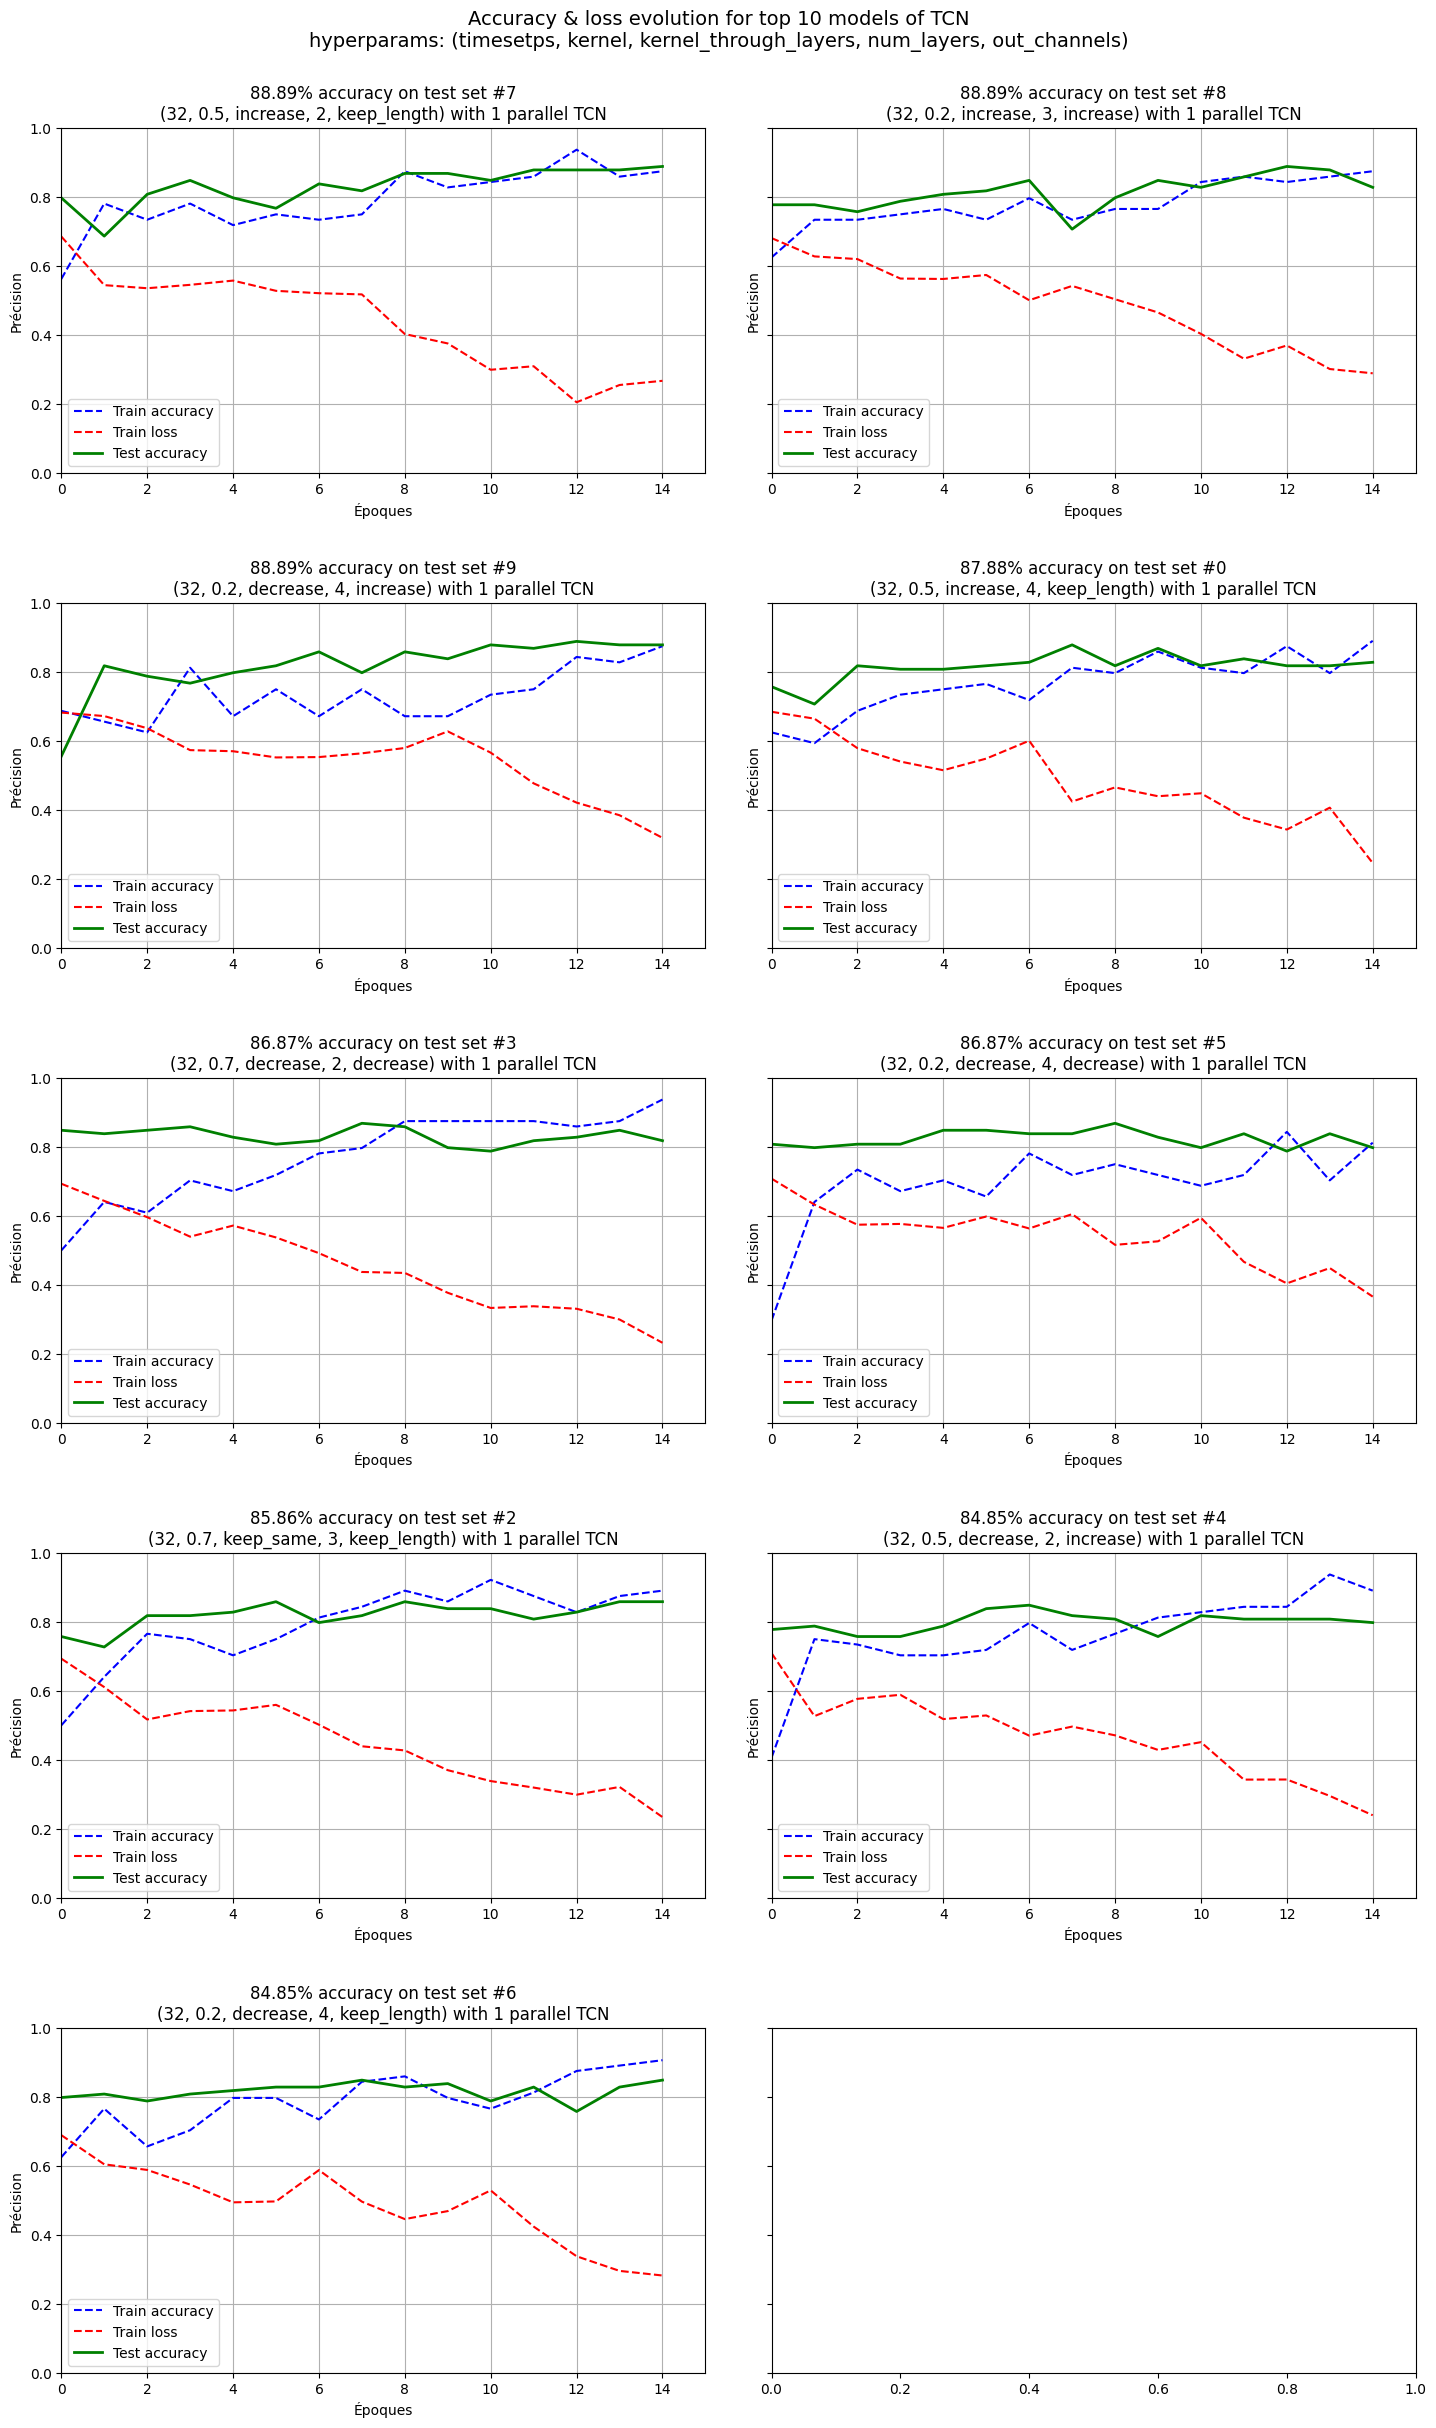

In [63]:
plot_best_models("best_models_with_cdata_multi_input.json")

In [ ]:
# use Dataset object and TCN with best hyperparameters
import json

def set_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(0)

results = pd.read_csv("results.csv")
results["max_accuracy_train"] = results["accuracy_train"].apply(lambda x: max(x))

NB_MODELS = 10
best_models = results.sort_values("accuracy_test", ascending=False).head(NB_MODELS)
criterion = nn.CrossEntropyLoss()
# redo best models training on ParalleleTCN with Dataset object
for index, (_, row) in enumerate(best_models.iterrows()):
    if index == 1: continue # trop lent

    
    if Dataset.TRAIN.get_timestep() != row["timestep"]:
        Dataset.TRAIN.set_timestep(row["timestep"])
        Dataset.TEST.set_timestep(row["timestep"])

    model = ParalleleTCN(timestep=row["timestep"], kernel_size=row["kernel_size"], kernel_ev=row["kernel_size_through_layers"], num_layers=row["num_layers"], out_layers=row["out_layers"], nb_parallel=3, num_feature=Dataset.TRAIN.num_features)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)


    model.to(device)
    model.train()

    for epoch in range(1, 11):
        for file_name, dataloader in Dataset.TRAIN:
            for i, (X_batch, y_batch) in enumerate(dataloader):

                # Forward pass
                optimizer.zero_grad()
                outputs = model(X_batch)
                print(outputs.shape, y_batch.shape)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        scheduler.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for file_name, dataloader in Dataset.TEST:
                for X_batch, y_batch in dataloader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs.data, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch}: Test accuracy: {accuracy}")

    



RuntimeError: 0D or 1D target tensor expected, multi-target not supported